In [1]:
import os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime, timedelta, date, time
import scipy.signal
import ee
from sklearn import linear_model
import statsmodels.formula.api as smf
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

In [ ]:
#Load Data
df0=pd.read_excel("/content/7_13_2021.xlsx")
df1=pd.read_excel("/content/7_21_2021.xlsx")
df2=pd.read_excel("/content/7_26_2021.xlsx")
df3=pd.read_excel("/content/8_02_2021.xlsx")
df4=pd.read_excel("/content/8_10_2021.xlsx")
df5=pd.read_excel("/content/8_17_2021.xlsx")
df6=pd.read_excel("/content/8_25_2021.xlsx")
df7=pd.read_excel("/content/9_01_2021.xlsx")
df8=pd.read_excel("/content/9_09_2021.xlsx")
df9=pd.read_excel("/content/9_16_2021.xlsx")
df0=df0.drop(['EWT_g/mm2'],axis=1)

<ipython-input-3-5388702402f5>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df0.append(df1).append(df2).append(df3).append(df4).append(df5).append(df6).append(df7).append(df8).append(df9)
<ipython-input-3-5388702402f5>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df0.append(df1).append(df2).append(df3).append(df4).append(df5).append(df6).append(df7).append(df8).append(df9)
<ipython-input-3-5388702402f5>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df0.append(df1).append(df2).append(df3).append(df4).append(df5).append(df6).append(df7).append(df8).append(df9)
<ipython-input-3-5388702402f5>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

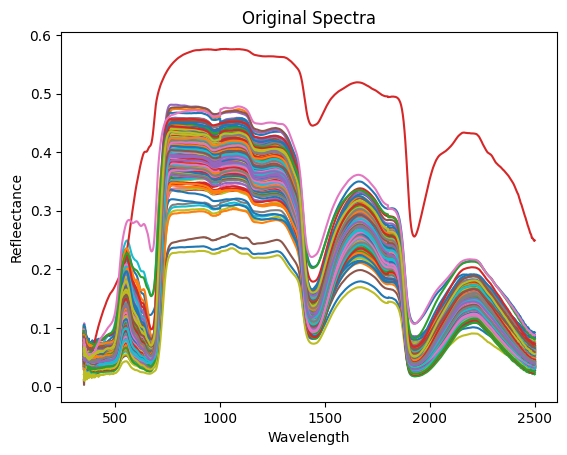

<ipython-input-3-5388702402f5>:33: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor=total.corr()


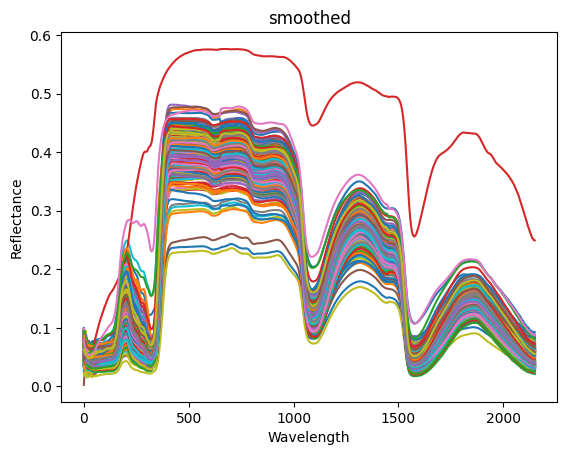

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Load the spectral data
#spectra = np.loadtxt('spectra.csv', delimiter=',')
df=df0.append(df1).append(df2).append(df3).append(df4).append(df5).append(df6).append(df7).append(df8).append(df9)
#df=df[df["Date"]!="2021-07-13"]
df=df.reset_index()
spectra=df.loc[:,350:]
EWT=df.loc[:,:"Plant#"]

# Define the window size and polynomial order for the Savitzky-Golay filter
window_size = 11
poly_order = 2

# Apply the Savitzky-Golay filter to smooth the spectra
smoothed = savgol_filter(spectra, window_size, poly_order,deriv=0, axis=1)
# Perform continuum removal by dividing the original spectra by the smoothed spectra
continuum_removed = spectra / smoothed
# Plot the original spectra and the continuum removed spectra
plt.plot(spectra.T)
plt.title('Original Spectra')
plt.xlabel('Wavelength')
plt.ylabel('Refleectance')
plt.show()
plt.plot(smoothed.T)
plt.title('smoothed')
plt.xlabel('Wavelength')
plt.ylabel('Reflectance')
s=pd.DataFrame(smoothed,columns=[i for i in range(350,2501)])
total=EWT.join(s)
cor=total.corr()
#total.corr()["EWT"].plot()
#result = cor[(cor['EWT'] > 0.6) | (cor['EWT'] < -0.6)]

In [ ]:
#Vegetation Indices
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from scipy.stats import ttest_rel
from scipy.stats import spearmanr
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
import math


total=total[total["Date"]!="2021-07-13"]
df=total

df["NDWI"]=(df[560]-df[835])/(df[560]+df[835]) #Gao 1996
df["NDII"]=(df[835]-df[1650])/(df[835]+df[1650]) #
df["MSI"]=df[1600]/df[820]
df["SIWSI"]=(df[858]-df[1640])/(df[858]+df[1640]) #
df["GVMI"]=((df[819]+0.1)-(df[1600]+0.02))/((df[819]+0.1)+(df[1600]+0.02))
df["fWBI"]=df[900]/df.loc[:, 930:980].min(axis=1)
df["WI"]=df[900]/df[970]
df["SRWI"]=df[1350]/df[870]
df["NDVI"]=(df[850]-df[670])/(df[850]+df[670])
df["ZTM"]=df[750]/df[710]
df["NMIR"]=(df[1390]-df[1370])/(df[1390]+df[1370])

VI=["NDWI"]

#Top
dft=df[df["Position"]=="T"]
X=dft[VI]
y=dft["EWT"]
score_standard="neg_root_mean_squared_error"
test_size=0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
lr_modelt = LinearRegression()
lr_modelt.fit(X_train, y_train)
y_pred = lr_modelt.predict(X_test)
r2 = r2_score(y_test, y_pred)
correlation = np.corrcoef(y_test, y_pred)[0,1]
print(['Pearson correlation coefficient: ', correlation],('T R2 score: ', r2))
rho, p_value = spearmanr(X, y)
print(["Spearman correlation coefficient:",rho],["pvalues",p_value])
scorest = cross_val_score(lr_modelt, X, y, cv=10, scoring=score_standard)
scorest = np.abs(scorest)
print("T score",scorest)
#Statmodel OLS model
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
X_test = sm.add_constant(X_test)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('OLS R-squared:', r2)
print("mse:",math.sqrt(mse))
print(model.summary())


dfe=df[df["Position"]=="E"]
X=dfe[VI]
y=dfe["EWT"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
lr_modele = LinearRegression()
lr_modele.fit(X_train, y_train)
y_pred = lr_modele.predict(X_test)
r2 = r2_score(y_test, y_pred)
correlation = np.corrcoef(y_test, y_pred)[0,1]
print(['Pearson correlation coefficient: ', correlation],('E R2 score: ', r2))
rho, p_value = spearmanr(X, y)
print(["Spearman correlation coefficient:",rho],["pvalues",p_value])
scorese = cross_val_score(lr_modele, X, y, cv=10, scoring=score_standard)
scorese = np.abs(scorese)
print("E score",scorese)
#Statmodel OLS model
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
X_test = sm.add_constant(X_test)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('OLS R-squared:', r2)
print(model.summary())


dfb=df[df["Position"]=="B"]
X=dfb[VI]
y=dfb["EWT"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
lr_modelb = LinearRegression()
lr_modelb.fit(X_train, y_train)
y_pred = lr_modelb.predict(X_test)
r2 = r2_score(y_test, y_pred)
correlation = np.corrcoef(y_test, y_pred)[0,1]
print(['Pearson correlation coefficient: ', correlation],('B R2 score: ', r2))
rho, p_value = spearmanr(X, y)
print(["Spearman correlation coefficient:",rho],["pvalues",p_value])
scoresb = cross_val_score(lr_modelb, X, y, cv=10, scoring=score_standard)
scoresb = np.abs(scoresb)
print("B score",scoresb)
#Statmodel OLS model
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
X_test = sm.add_constant(X_test)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('OLS R-squared:', r2)
print(model.summary())


df_score=pd.DataFrame(scorest,columns=["T"])
df_score["E"],df_score["B"]=scorese,scoresb
df_melt= pd.melt(df_score, value_vars=['T','E',"B"], var_name='Position', value_name="EWT")
df_score["Features"]=VI[0]
model = ols('EWT ~ C(Position)', data=df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
p_value = anova_table['PR(>F)']['C(Position)']
print(p_value)

if p_value < 0.05:
    # If there's a significant effect, perform post-hoc test
    mc = MultiComparison(df_melt["EWT"], df_melt['Position'])
    result = mc.tukeyhsd()
    # Print summary of the test
    print(result.summary())
    # Plot graph of the test
    fig = result.plot_simultaneous()
    fig.show()
else:
    # If there's no significant effect, print a message
    print("No significant effect found.")

<ipython-input-4-02eba93a1348>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["NDWI"]=(df[560]-df[835])/(df[560]+df[835]) #Gao 1996
<ipython-input-4-02eba93a1348>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["NDII"]=(df[835]-df[1650])/(df[835]+df[1650]) #
<ipython-input-4-02eba93a1348>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

['Pearson correlation coefficient: ', 0.5345818027811318] ('T R2 score: ', 0.23308149894646446)
['Spearman correlation coefficient:', -0.40352361140471404] ['pvalues', 9.239769194739445e-08]
T score [0.00117756 0.00130982 0.00119312 0.0013742  0.00098507 0.00118063
 0.00144075 0.00112106 0.00076359 0.00111428]
OLS R-squared: 0.2330814989464638
mse: 0.0012765795351819748
                            OLS Regression Results                            
Dep. Variable:                    EWT   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     20.59
Date:                Sat, 13 May 2023   Prob (F-statistic):           1.30e-05
Time:                        20:47:35   Log-Likelihood:                 697.05
No. Observations:                 130   AIC:                            -1390.
Df Residuals:                     128   BIC:                            -1

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold
total=total[total["Date"]!="2021-07-13"]
df=total
test_size=0.4
dft=df[df["Position"]=="B"]
X=dft.loc[:,400:2500]
y=dft["EWT"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
param_grid = {'max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}
tree_reg = DecisionTreeRegressor(random_state=0,max_features="log2")
grid_search = GridSearchCV(tree_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print("maximum depth:", grid_search.best_params_)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
param_grid = {'max_leaf_nodes': [i for i in range(1,51)],}
tree_reg = DecisionTreeRegressor(random_state=None,max_depth=2,max_features="log2")
grid_search = GridSearchCV(tree_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print("max leaf node:", grid_search.best_params_)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
tree_reg = DecisionTreeRegressor(random_state=0,max_depth=2,max_leaf_nodes=24,max_features="log2")
tree_reg.fit(X_train, y_train)
y_pred = tree_reg.predict(X_test)
print("r2",r2_score(y_test, y_pred))
print("importance",tree_reg.feature_importances_)
print("r",np.corrcoef(y_test, y_pred)[0,1])

maximum depth: {'max_depth': 2}
max leaf node: {'max_leaf_nodes': 24}
r2 -0.03764266650371373
importance [0. 0. 0. ... 0. 0. 0.]
r 0.28139343691204943


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 1247, in fit
    super().fit(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validat

r2 -0.24846739384311478
T R 0.2474354753834189
T score [0.00157068 0.00156314 0.00183901 0.00146251 0.00183676 0.00150729
 0.00169611 0.00184929 0.00092972 0.0012207 ]
r2 0.1284379194789118
E R 0.3620612722767046
E score [0.00098262 0.00112351 0.00073248 0.00133767 0.00138073 0.0011965
 0.0012896  0.00133184 0.00115089 0.00141457]
r2 -0.025548453094444534
B R 0.24782411425749784
B score [0.00098262 0.00112351 0.00073248 0.00133767 0.00138073 0.0011965
 0.0012896  0.00133184 0.00115089 0.00141457]


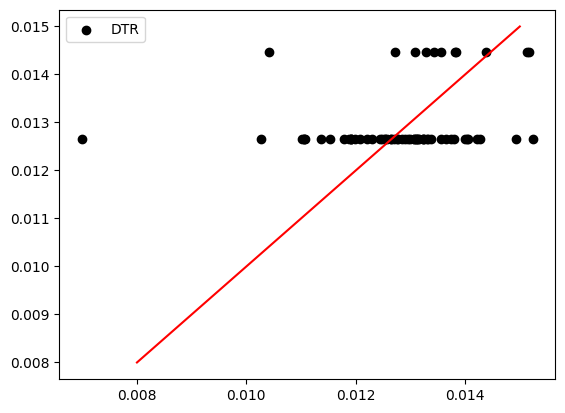

0.2313657589541486
No significant effect found.


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

total=total[df["Date"]!="2021-07-13"]
df=total
test_size=0.4

dft=df[df["Position"]=="T"]
X=dft.loc[:,400:2500]
y=dft["EWT"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
tree_reg = DecisionTreeRegressor(random_state=0,max_depth=3,max_leaf_nodes=4,max_features="log2")
tree_reg = DecisionTreeRegressor(random_state=0)
tree_reg.fit(X_train, y_train)
y_pred = tree_reg.predict(X_test)
correlation = np.corrcoef(y_test, y_pred)
print("r2",r2_score(y_test, y_pred))
print('T R', correlation[0,1])
scorest = cross_val_score(tree_reg, X, y, cv=10, scoring=score_standard)
scorest = np.abs(scorest)
print("T score",scorest)

dfe=df[df["Position"]=="E"]
X=dfe.loc[:,400:2500]
y=dfe["EWT"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
tree_reg = DecisionTreeRegressor(random_state=0,max_depth=2,max_leaf_nodes=19,max_features="log2")
tree_reg.fit(X_train, y_train)
y_pred = tree_reg.predict(X_test)
correlation = np.corrcoef(y_test, y_pred)
print("r2",r2_score(y_test, y_pred))
print('E R', correlation[0,1])
scorese = cross_val_score(tree_reg, X, y, cv=10, scoring=score_standard)
scorese = np.abs(scorese)
print("E score",scorese)

dfe=df[df["Position"]=="B"]
X=dfb.loc[:,400:2500]
y=dfb["EWT"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
tree_reg = DecisionTreeRegressor(random_state=0,max_depth=2,max_leaf_nodes=24,max_features="log2")
tree_reg.fit(X_train, y_train)
y_pred = tree_reg.predict(X_test)
correlation = np.corrcoef(y_test, y_pred)
print("r2",r2_score(y_test, y_pred))
print('B R', correlation[0,1])
scoresb = cross_val_score(tree_reg, X, y, cv=10, scoring=score_standard)
scoresb = np.abs(scoresb)
print("B score",scorese)


plt.scatter(y_test, y_pred, color='black', label='DTR')
plt.plot([0.008,0.015], [0.008,0.015], color='red')
plt.legend()
plt.show()

df_score=pd.DataFrame(scorest,columns=["T"])#.append(scorese).append(scoresb)
df_score["E"],df_score["B"]=scorese,scoresb
df_score["Features"]="DTR"
df_melt= pd.melt(df_score, value_vars=['T','E',"B"], var_name='Position', value_name='EWT')

model = ols('EWT ~ C(Position)', data=df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
p_value = anova_table['PR(>F)']['C(Position)']
print(p_value)

if p_value < 0.05:
    # If there's a significant effect, perform post-hoc test
    mc = MultiComparison(df_melt['EWT'], df_melt['Position'])
    result = mc.tukeyhsd()
    # Print summary of the test
    print(result.summary())
    # Plot graph of the test
    fig = result.plot_simultaneous()
    fig.show()
else:
    # If there's no significant effect, print a message
    print("No significant effect found.")
#RMSE=RMSE.append(df_score)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from sklearn.model_selection import GridSearchCV, KFold
total=total[df["Date"]!="2021-07-13"]
df=total
test_size=0.2

dft=df[df["Position"]=="B"]
X=dft.loc[:,400:2500]
y=dft["EWT"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
param_grid = {'max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}
rf_model = RandomForestRegressor(n_estimators=100, random_state=0,max_features="log2")
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print("maximum depth:", grid_search.best_params_)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
param_grid = {'max_leaf_nodes': [i for i in range(1,51)],}
rf_model = RandomForestRegressor(n_estimators=100, random_state=0,max_features="log2",max_depth=9)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print("max_depth:", grid_search.best_params_)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
rf_model = RandomForestRegressor(random_state=0,max_depth=9,max_leaf_nodes=12,max_features="log2")
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print("r2",r2_score(y_test, y_pred))
print("importance",rf_model.feature_importances_)
print("r",np.corrcoef(y_test, y_pred)[0,1])

maximum depth: {'max_depth': 9}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/

max_depth: {'max_leaf_nodes': 12}
r2 0.21778767707879831
importance [0.         0.         0.00188524 ... 0.00027211 0.00502019 0.00154754]
r 0.48839222616115924


T R-squared score: 0.4601652582202561
T R 0.6681301040494221
T score [0.001112   0.00115165 0.00121772 0.00140412 0.00114736 0.0010924
 0.00125507 0.001168   0.0006342  0.00102167]
E R-squared score: 0.4601652582202561
E R 0.5210866010646364
E score [0.00106534 0.00088642 0.00078972 0.00118683 0.00127092 0.00104445
 0.0010885  0.00092246 0.00097423 0.00125588]
B R-squared score: 0.4601652582202561
B R 0.48839222616115924
B score [0.00106534 0.00088642 0.00078972 0.00118683 0.00127092 0.00104445
 0.0010885  0.00092246 0.00097423 0.00125588]


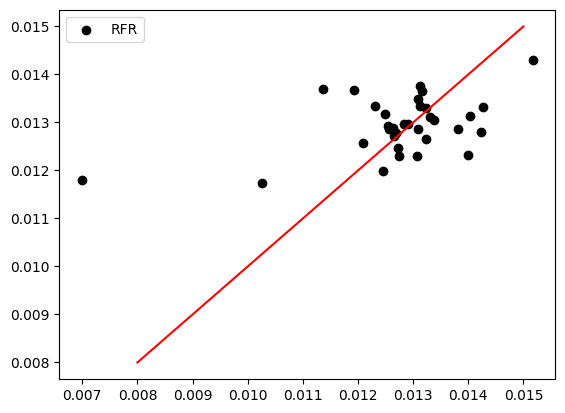

0.1884215716026734
No significant effect found.


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

total=total[df["Date"]!="2021-07-13"]
df=total
test_size=0.2
# split data into training and testing sets

dft=df[df["Position"]=="T"]
X=dft.loc[:,400:2500]
y=dft["EWT"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
rf_model = RandomForestRegressor(random_state=0,max_depth=8,max_leaf_nodes=38,max_features="log2")
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
correlation = np.corrcoef(y_test, y_pred)
print('T R-squared score:', r2)
print('T R', correlation[0,1])
scorest = cross_val_score(rf_model, X, y, cv=10, scoring=score_standard)
scorest = np.abs(scorest)
print("T score",scorest)

dfe=df[df["Position"]=="E"]
X=dfe.loc[:,400:2500]
y=dfe["EWT"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
rf_model = RandomForestRegressor(random_state=0,max_depth=8,max_leaf_nodes=48,max_features="log2")
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
correlation = np.corrcoef(y_test, y_pred)
print('E R-squared score:', r2)
print('E R', correlation[0,1])
scorese = cross_val_score(rf_model, X, y, cv=10, scoring=score_standard)
scorese = np.abs(scorese)
print("E score",scorese)

dfe=df[df["Position"]=="B"]
X=dfb.loc[:,400:2500]
y=dfb["EWT"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
rf_model = RandomForestRegressor(random_state=0,max_depth=9,max_leaf_nodes=12,max_features="log2")
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
correlation = np.corrcoef(y_test, y_pred)
print('B R-squared score:', r2)
print('B R', correlation[0,1])
scoresb = cross_val_score(rf_model, X, y, cv=10, scoring=score_standard)
scoresb = np.abs(scoresb)
print("B score",scorese)


plt.scatter(y_test, y_pred, color='black', label='RFR')
plt.plot([0.008,0.015], [0.008,0.015], color='red')
plt.legend()
plt.show()

df_score=pd.DataFrame(scorest,columns=["T"])#.append(scorese).append(scoresb)
df_score["E"],df_score["B"]=scorese,scoresb
df_score["Features"]="RFR"
df_melt= pd.melt(df_score, value_vars=['T','E',"B"], var_name='Position', value_name='EWT')

model = ols('EWT ~ C(Position)', data=df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
p_value = anova_table['PR(>F)']['C(Position)']
print(p_value)

if p_value < 0.05:
    # If there's a significant effect, perform post-hoc test
    mc = MultiComparison(df_melt['EWT'], df_melt['Position'])
    result = mc.tukeyhsd()
    # Print summary of the test
    print(result.summary())
    # Plot graph of the test
    fig = result.plot_simultaneous()
    fig.show()
else:
    # If there's no significant effect, print a message
    print("No significant effect found.")

In [ ]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, KFold
total=total[total["Date"]!="2021-07-13"]
df=total
test_size=0.2
dft=df[df["Position"]=="B"]
X=dft.loc[:,400:2500]
y=dft["EWT"]

max_components = 51
plsr = PLSRegression()
cv_scores = []
for n_components in range(1, max_components + 1):
    plsr.n_components = n_components
    scores = cross_val_score(plsr, X, y, cv=10,scoring="neg_mean_squared_error")  # 5-fold cross-validation
    cv_scores.append(np.mean(scores))

optimal_n_components = np.argmax(cv_scores) + 1
print("optimal n component",optimal_n_components)

# Create the PLSR model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
n_components = 5
pls_model = PLSRegression(n_components=n_components)
pls_model.fit(X_train, y_train)
y_pred = pls_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
a=[i for [i] in y_pred]
b=[i for i in y_test]
correlation = np.corrcoef(b, a)
print('T R-squared score:', r2)
print('T R', correlation[0,1])

optimal n component 5
T R-squared score: 0.4601652582202561
T R 0.6937031881601674


T R-squared score: 0.7894260337442337
T R 0.8940050989391902
T score [0.00060977 0.00065305 0.00072724 0.00101683 0.00061182 0.00089135
 0.00094804 0.00080028 0.00070573 0.00091302]
E R-squared score: 0.46633124073729515
E R 0.7029499850798439
E score [0.00076727 0.00067383 0.00068859 0.00106363 0.00108026 0.0008987
 0.00097849 0.00084416 0.00073778 0.00051212]
B R 0.6937031881601674
B R-squared score: 0.4601652582202561
E score [0.00117186 0.00109137 0.00059118 0.00120469 0.0010393  0.00078148
 0.00061409 0.001083   0.00078268 0.00125368]


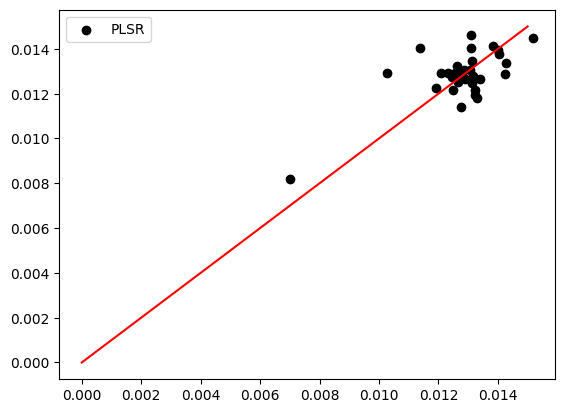

0.13484214719583523
No significant effect found.


In [ ]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score

total=total[df["Date"]!="2021-07-13"]
df=total

# Load the dataset
dft=df[df["Position"]=="T"]
X=dft.loc[:,400:2500]
y=dft["EWT"]
score_standard="neg_root_mean_squared_error"

test_size=0.2
# Create the PLSR model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
n_components = 10
pls_model = PLSRegression(n_components=n_components)
# Fit the model to the training data
pls_model.fit(X_train, y_train)
# Predict the test data
y_pred = pls_model.predict(X_test)

# Compute the R-squared score
r2 = r2_score(y_test, y_pred)
a=[i for [i] in y_pred]
b=[i for i in y_test]
correlation = np.corrcoef(b, a)
print('T R-squared score:', r2)
print('T R', correlation[0,1])
scorest = cross_val_score(pls_model, X, y, cv=10, scoring=score_standard)
scorest = np.abs(scorest)
print("T score",scorest)

dfe=df[df["Position"]=="E"]
X=dfe.loc[:,400:2500]
y=dfe["EWT"]
# Create the PLSR model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
n_components = 5
pls_model = PLSRegression(n_components=n_components)
# Fit the model to the training data
pls_model.fit(X_train, y_train)
# Predict the test data
y_pred = pls_model.predict(X_test)
# Compute the R-squared score
r2 = r2_score(y_test, y_pred)
a=[i for [i] in y_pred]
b=[i for i in y_test]
correlation = np.corrcoef(b, a)
print('E R-squared score:', r2)
print('E R', correlation[0,1])
scorese = cross_val_score(pls_model, X, y, cv=10, scoring=score_standard)
scorese = np.abs(scorese)
print("E score",scorese)


dfb=df[df["Position"]=="B"]
X=dfb.loc[:,400:2500]
y=dfb["EWT"]
# Create the PLSR model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
n_components = 5
pls_model = PLSRegression(n_components=n_components)
# Fit the model to the training data
pls_model.fit(X_train, y_train)
# Predict the test data
y_pred = pls_model.predict(X_test)
# Compute the R-squared score
r2 = r2_score(y_test, y_pred)
a=[i for [i] in y_pred]
b=[i for i in y_test]
correlation = np.corrcoef(b, a)
print('B R', correlation[0,1])
print('B R-squared score:', r2)
scoresb = cross_val_score(pls_model, X, y, cv=10, scoring=score_standard)
scoresb = np.abs(scoresb)
print("E score",scoresb)


plt.scatter(y_test, y_pred, color='black', label='PLSR')
plt.plot([0.000,0.015], [0.000,0.015], color='red')
plt.legend()
plt.show()

df_score=pd.DataFrame(scorest,columns=["T"])#.append(scorese).append(scoresb)
df_score["E"],df_score["B"]=scorese,scoresb
df_score["Features"]="PLSR"
df_melt= pd.melt(df_score, value_vars=['T','E',"B"], var_name='Position', value_name='EWT')

model = ols('EWT ~ C(Position)', data=df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
p_value = anova_table['PR(>F)']['C(Position)']
print(p_value)

if p_value < 0.05:
    # If there's a significant effect, perform post-hoc test
    mc = MultiComparison(df_melt['EWT'], df_melt['Position'])
    result = mc.tukeyhsd()
    # Print summary of the test
    print(result.summary())
    # Plot graph of the test
    fig = result.plot_simultaneous()
    fig.show()
else:
    # If there's no significant effect, print a message
    print("No significant effect found.")
#RMSE=RMSE.append(df_score)

<ipython-input-3-4df5ed5bc780>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df0.append(df1).append(df2).append(df3).append(df4).append(df5).append(df6).append(df7).append(df8).append(df9)
<ipython-input-3-4df5ed5bc780>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df0.append(df1).append(df2).append(df3).append(df4).append(df5).append(df6).append(df7).append(df8).append(df9)
<ipython-input-3-4df5ed5bc780>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df0.append(df1).append(df2).append(df3).append(df4).append(df5).append(df6).append(df7).append(df8).append(df9)
<ipython-input-3-4df5ed5bc780>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

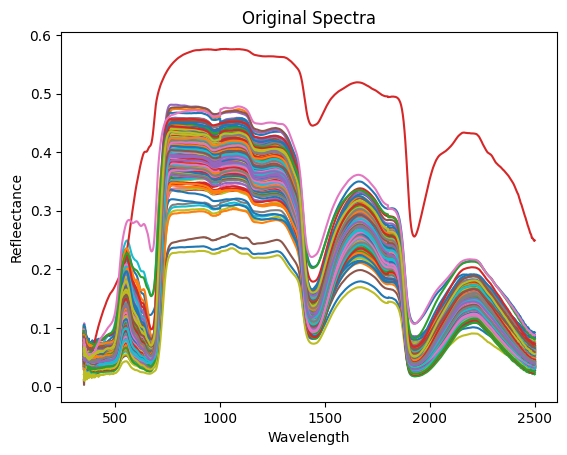

<ipython-input-3-4df5ed5bc780>:33: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor=total.corr()


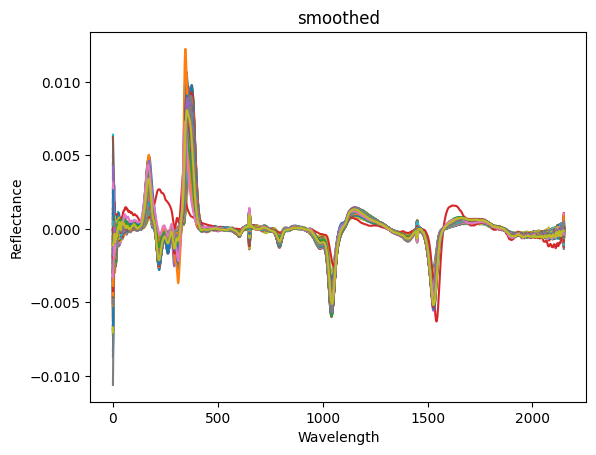

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Load the spectral data
#spectra = np.loadtxt('spectra.csv', delimiter=',')
df=df0.append(df1).append(df2).append(df3).append(df4).append(df5).append(df6).append(df7).append(df8).append(df9)
#df=df[df["Date"]!="2021-07-13"]
df=df.reset_index()
spectra=df.loc[:,350:]
EWT=df.loc[:,:"Plant#"]

# Define the window size and polynomial order for the Savitzky-Golay filter
window_size = 11
poly_order = 2

# Apply the Savitzky-Golay filter to smooth the spectra
smoothed = savgol_filter(spectra, window_size, poly_order,deriv=1, axis=1)
# Perform continuum removal by dividing the original spectra by the smoothed spectra
continuum_removed = spectra / smoothed
# Plot the original spectra and the continuum removed spectra
plt.plot(spectra.T)
plt.title('Original Spectra')
plt.xlabel('Wavelength')
plt.ylabel('Refleectance')
plt.show()
plt.plot(smoothed.T)
plt.title('smoothed')
plt.xlabel('Wavelength')
plt.ylabel('Reflectance')
s=pd.DataFrame(smoothed,columns=[i for i in range(350,2501)])
total=EWT.join(s)
cor=total.corr()
#total.corr()["EWT"].plot()
#result = cor[(cor['EWT'] > 0.6) | (cor['EWT'] < -0.6)]

-0.6234482774189204

T R2 score:  0.606285933601248
T R score: 0.8565410755607025
T score [0.00095547 0.00093509 0.00098943 0.00095328 0.00104766 0.00092016
 0.00108353 0.00108031 0.00083169 0.00114811]
E R2 score:  0.32831714341109075
E R score: 0.6220096815947508
E score [0.00090329 0.00080595 0.00055312 0.00118852 0.00102791 0.00100391
 0.00100394 0.00089624 0.0008126  0.00070051]
B R2 score:  0.5699068589277811
B R score: 0.7899584159372552
B score [0.00167944 0.00107241 0.00075363 0.00138498 0.00113196 0.00092012
 0.00074608 0.00127109 0.0012225  0.00139637]
0.02562876740424335
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     B      E  -0.0003 0.0204 -0.0005   -0.0   True
     B      T  -0.0002 0.2044 -0.0004 0.0001  False
     E      T   0.0001 0.5071 -0.0001 0.0003  False
---------------------------------------------------


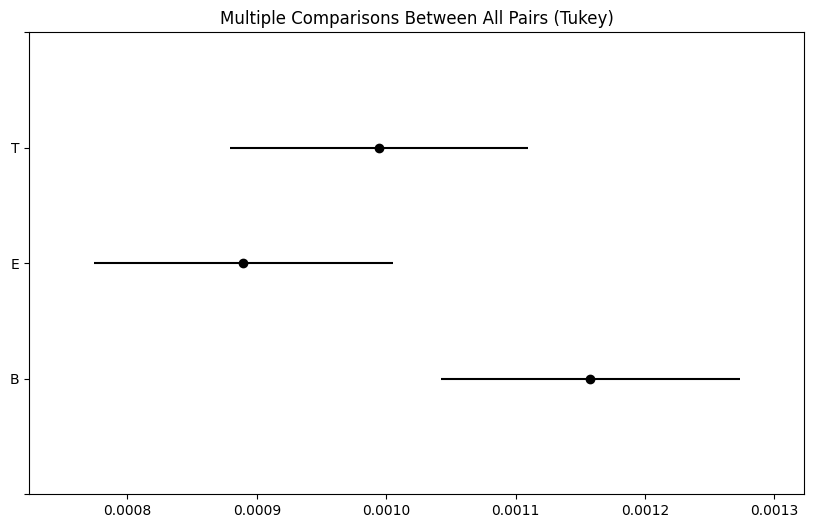

In [ ]:
#Bands
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from scipy.stats import ttest_rel
from scipy.stats import spearmanr
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold

VI=2003
total=total[total["Date"]!="2021-07-13"]
test_size=0.2
df=total
dft=df[df["Position"]=="T"]
X=dft[[VI]]
y=dft["EWT"]
score_standard="neg_root_mean_squared_error"
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
lr_modelt = LinearRegression()
lr_modelt.fit(X_train, y_train)
y_pred = lr_modelt.predict(X_test)
r2 = r2_score(y_test, y_pred)
correlation = np.corrcoef(y_test, y_pred)[0,1]
print('T R2 score: ', r2)
print("T R score:",correlation)
scorest = cross_val_score(lr_modelt, X, y, cv=10, scoring=score_standard)
scorest = np.abs(scorest)
print("T score",scorest)

dfe=df[df["Position"]=="E"]
X=dfe[[VI]]
y=dfe["EWT"]
score_standard="neg_root_mean_squared_error"
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
lr_modele = LinearRegression()
lr_modele.fit(X_train, y_train)
y_pred = lr_modele.predict(X_test)
r2 = r2_score(y_test, y_pred)
correlation = np.corrcoef(y_test, y_pred)[0,1]
print('E R2 score: ', r2)
print("E R score:",correlation)
scorese = cross_val_score(lr_modele, X, y, cv=10, scoring=score_standard)
scorese = np.abs(scorese)
print("E score",scorese)

dfb=df[df["Position"]=="B"]
X=dfb[[VI]]
y=dfb["EWT"]
score_standard="neg_root_mean_squared_error"
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
lr_modelb = LinearRegression()
lr_modelb.fit(X_train, y_train)
y_pred = lr_modelb.predict(X_test)
r2 = r2_score(y_test, y_pred)
correlation = np.corrcoef(y_test, y_pred)[0,1]
print('B R2 score: ', r2)
print("B R score:",correlation)
scoresb = cross_val_score(lr_modelb, X, y, cv=10, scoring=score_standard)
scoresb = np.abs(scoresb)
print("B score",scoresb)

df_score=pd.DataFrame(scorest,columns=["T"])#.append(scorese).append(scoresb)
df_score["E"],df_score["B"]=scorese,scoresb
df_score["Features"]=2003
df_melt= pd.melt(df_score, value_vars=['T','E',"B"], var_name='Position', value_name='EWT')

model = ols('EWT ~ C(Position)', data=df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
p_value = anova_table['PR(>F)']['C(Position)']
print(p_value)

if p_value < 0.05:
    # If there's a significant effect, perform post-hoc test
    mc = MultiComparison(df_melt['EWT'], df_melt['Position'])
    result = mc.tukeyhsd()
    # Print summary of the test
    print(result.summary())
    # Plot graph of the test
    fig = result.plot_simultaneous()
    fig.show()
else:
    # If there's no significant effect, print a message
    print("No significant effect found.")

In [ ]:
for i in range (1800,2501):
  VI=i
  total=total[total["Date"]!="2021-07-13"]
  test_size=0.2
  df=total
  dft=df[df["Position"]=="T"]
  X=dft[[VI]]
  y=dft["EWT"]
  score_standard="neg_root_mean_squared_error"
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
  lr_modelt = LinearRegression()
  lr_modelt.fit(X_train, y_train)
  y_pred = lr_modelt.predict(X_test)
  scorest = cross_val_score(lr_modelt, X, y, cv=10, scoring=score_standard)
  scorest = np.abs(scorest)

  dfe=df[df["Position"]=="E"]
  X=dfe[[VI]]
  y=dfe["EWT"]
  score_standard="neg_root_mean_squared_error"
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
  lr_modele = LinearRegression()
  lr_modele.fit(X_train, y_train)
  y_pred = lr_modele.predict(X_test)
  scorese = cross_val_score(lr_modele, X, y, cv=10, scoring=score_standard)
  scorese = np.abs(scorese)

  dfb=df[df["Position"]=="B"]
  X=dfb[[VI]]
  y=dfb["EWT"]
  score_standard="neg_root_mean_squared_error"
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
  lr_modelb = LinearRegression()
  lr_modelb.fit(X_train, y_train)
  y_pred = lr_modelb.predict(X_test)
  r2 = r2_score(y_test, y_pred)
  correlation = np.corrcoef(y_test, y_pred)[0,1]
  scoresb = cross_val_score(lr_modelb, X, y, cv=10, scoring=score_standard)
  scoresb = np.abs(scoresb)

  df_score=pd.DataFrame(scorest,columns=["T"])#.append(scorese).append(scoresb)
  df_score["E"],df_score["B"]=scorese,scoresb
  df_score["Features"]=2003
  df_melt= pd.melt(df_score, value_vars=['T','E',"B"], var_name='Position', value_name='EWT')

  model = ols('EWT ~ C(Position)', data=df_melt).fit()
  anova_table = sm.stats.anova_lm(model, typ=2)
  p_value = anova_table['PR(>F)']['C(Position)']

  if p_value < 0.05:
    if correlation >=0.5:
      #print(i)

1903
1904
1905
1906
1907
1908
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1981
1982
1983
1984
1985
1986
1987
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2019
2020
2021
2022
2023
2024
2025
2026
2401
2402
2403
2404
2405
2406
2414
2436
2437
2464
2482


In [12]:
#Figure
from matplotlib import gridspec
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import StrMethodFormatter
import matplotlib.pyplot as plt
#Figure 2 bar graphes
RMSE = pd.read_excel("/RMSE.xlsx")
RMSE = RMSE.replace('NMIR', r'$\mathdefault{R_{1390}-R_{1370}/R_{1390}+R_{1370}}$')
RMSE = RMSE.rename(columns={'T': 'Top',"E":"Ear","B":"Bottom"})
RMSE = RMSE.replace({1987:"1987nm", 1898:"1898nm",2003:"2003nm",2402:"2402nm"})
RMSE_melt= pd.melt(RMSE, value_vars=['Top','Ear',"Bottom"], var_name='Position', value_name='RMSE',id_vars="Features")
RMSE_VI=RMSE_melt[RMSE_melt["Features"].isin(["NDWI","NDII","MSI","WI",r'$\mathdefault{R_{1390}-R_{1370}/R_{1390}+R_{1370}}$',"SIWSI"])]
RMSE_B=RMSE_melt[RMSE_melt["Features"].isin(["1898nm","1987nm","2003nm","2402nm"])]
RMSE_M=RMSE_melt[RMSE_melt["Features"].isin(["PLSR","RFR","DTR"])]
RMSE_VI=RMSE_VI[RMSE_VI["Features"]!=r'$\mathdefault{R_{1390}-R_{1370}/R_{1390}+R_{1370}}$']
RMSE_B=RMSE_B[RMSE_B["Features"]!="1898nm"]
textzie=110
ticksize=80
errwidth=10
fig_dims=(80,60)
fig, axes = plt.subplots(figsize=(90, 60),sharey=True)
textx=0.005
texty=0.94

my_colors = ["#c1272d", "#eecc16", "#008176"]
sns.set_palette(my_colors)
gs = gridspec.GridSpec(2, 8)
a=plt.subplot(gs[0,0:8])
a = sns.barplot(data=RMSE_VI,x="Features",y="RMSE",hue="Position", capsize=0.1, hue_order=["Top", "Ear","Bottom"],errwidth=errwidth)
a.tick_params(axis='x', labelsize=ticksize)
a.tick_params(axis='y', labelsize=ticksize)
a.set_ylabel(r'RMSE$\mathdefault{(g/mm^{2})}$',fontsize=textzie)
a.set_xlabel('Vegetation Indices',fontsize=textzie)
#a.legend(fontsize=90,facecolor = 'white', bbox_to_anchor=(1.15, 0))
a.legend_.remove()
a.text(textx, texty, "a)", transform=a.transAxes,fontsize=textzie)
for spine in a.spines.values():
    spine.set_color('black')
    spine.set_linewidth(4)
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-3, -3))
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().yaxis.offsetText.set_fontsize(ticksize)
plt.gca().yaxis.offsetText.set_x(0)


#b=plt.subplot(gs[1,0:6])
#b = sns.barplot(data=RMSE_B,x="Features",y="RMSE",hue="Position",capsize=0.1,errwidth=errwidth)
#b.tick_params(axis='x', labelsize=ticksize)
#b.tick_params(axis='y', labelsize=ticksize)
#b.set_ylabel(r'RMSE$\mathdefault{(g/mm^{2})}$',fontsize=textzie)
#b.legend(loc="upper left",fontsize=60,facecolor = 'white')
#b.set_xlabel('Wavebands of the First Derivative Leaf Reflectance',fontsize=textzie)
#b.text(textx, texty, "b)", transform=b.transAxes,fontsize=textzie)
#b.legend_.remove()
#for spine in b.spines.values():
    #spine.set_color('black')
    #spine.set_linewidth(4)
#formatter = ticker.ScalarFormatter(useMathText=True)
#formatter.set_scientific(True)
#formatter.set_powerlimits((-3, -3))
#plt.gca().yaxis.set_major_formatter(formatter)
#plt.gca().yaxis.offsetText.set_fontsize(ticksize)

c=plt.subplot(gs[1,2:6])
c = sns.barplot(data=RMSE_M,x="Features",y="RMSE",hue="Position",capsize=0.1,errwidth=errwidth)
c.tick_params(axis='x', labelsize=ticksize)
c.tick_params(axis='y', labelsize=ticksize)
c.set_ylabel(r'RMSE$\mathdefault{(g/mm^{2})}$',fontsize=textzie)
c.legend(loc="upper left",fontsize=60,facecolor = 'white')
c.set_xlabel('Models',fontsize=textzie)
c.text(textx, texty, "b)", transform=c.transAxes,fontsize=textzie)
c.legend_.remove()
for spine in c.spines.values():
    spine.set_color('black')
    spine.set_linewidth(4)
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-3, -3))
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().yaxis.offsetText.set_fontsize(ticksize)
plt.legend(fontsize=90,facecolor = 'white', bbox_to_anchor=(1, 1))
fig.tight_layout()
fig.savefig("Figure2.png", dpi=300)

<ipython-input-12-e8b8ff7b51ec>:29: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  a=plt.subplot(gs[0,0:8])
<ipython-input-12-e8b8ff7b51ec>:30: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 10}` instead.

  a = sns.barplot(data=RMSE_VI,x="Features",y="RMSE",hue="Position", capsize=0.1, hue_order=["Top", "Ear","Bottom"],errwidth=errwidth)
<ipython-input-12-e8b8ff7b51ec>:68: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 10}` instead.

  c = sns.barplot(data=RMSE_M,x="Features",y="RMSE",hue="Position",capsize=0.1,errwidth=errwidth)
